# Using Raster Vision with Lightning

In [ ]:
! pip install pytorch-lightning==1.8

## Define training and validation datasets

In [1]:
train_image_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/images/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif'
train_label_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/labels/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson'

In [2]:
val_image_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/images/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13.tif'
val_label_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/labels/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13_Buildings.geojson'

In [3]:
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset,
    SemanticSegmentationSlidingWindowGeoDataset,
    SemanticSegmentationVisualizer)
from rastervision.core.data import ClassConfig

import albumentations as A

class_config = ClassConfig(
    names=['background', 'building'], 
    colors=['lightgray', 'darkred'],
    null_class='background')

viz = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors)

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


### Training dataset with random-window sampling and data augmentation

In [4]:
data_augmentation_transform = A.Compose([
    A.Flip(),
    A.ShiftScaleRotate(),
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=10),
        A.RGBShift(),
        A.ToGray(),
        A.ToSepia(),
        A.RandomBrightness(),
        A.RandomGamma(),
    ]),
    A.CoarseDropout(max_height=32, max_width=32, max_holes=5)
])

train_ds = SemanticSegmentationRandomWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=train_image_uri,
    label_vector_uri=train_label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    size_lims=(150, 200),
    out_size=256,
    max_windows=400,
    transform=data_augmentation_transform)

len(train_ds)

2022-11-10 03:03:06:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/images/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif.
2022-11-10 03:03:06:rastervision.core.data.raster_source.rasterio_source: WARNING - Raster block size (2, 1024) is too non-square. This can slow down reading. Consider re-tiling using GDAL.
2022-11-10 03:03:06:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/labels/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson.


400

Visualize:

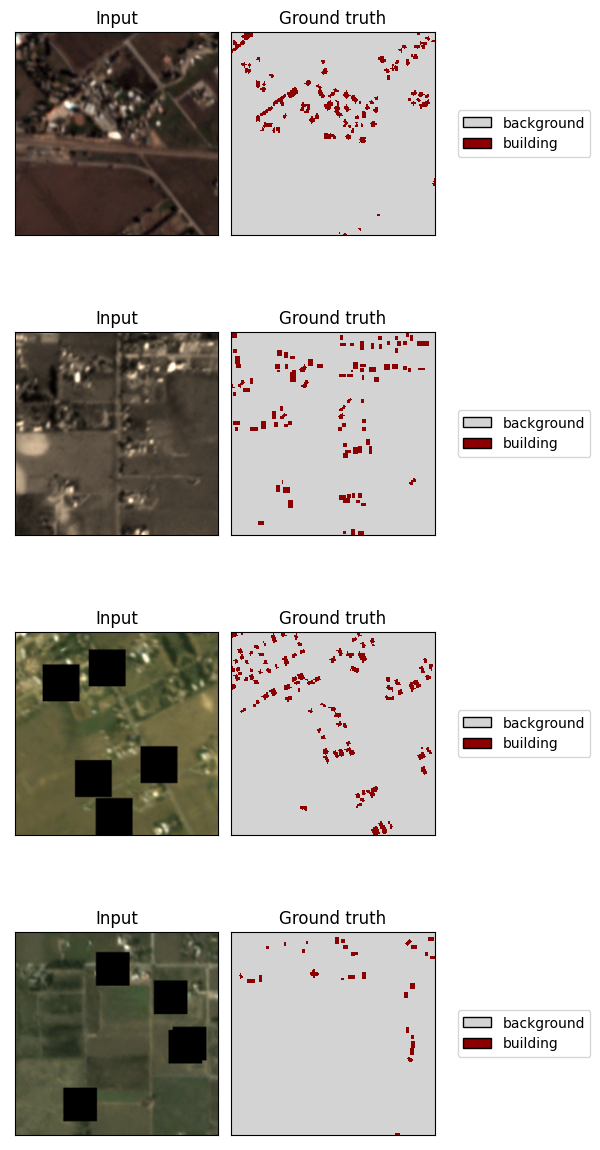

In [5]:
x, y = viz.get_batch(train_ds, 4)
viz.plot_batch(x, y, show=True)

### Validation dataset with sliding-window sampling and no data augmentation

In [6]:
val_ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=val_image_uri,
    label_vector_uri=val_label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    size=200,
    stride=200,
    transform=A.Resize(256, 256))

len(val_ds)

2022-11-10 03:03:41:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/images/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13.tif.
2022-11-10 03:03:41:rastervision.core.data.raster_source.rasterio_source: WARNING - Raster block size (2, 1024) is too non-square. This can slow down reading. Consider re-tiling using GDAL.
2022-11-10 03:03:41:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/labels/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13_Buildings.geojson.


25

Visualize:

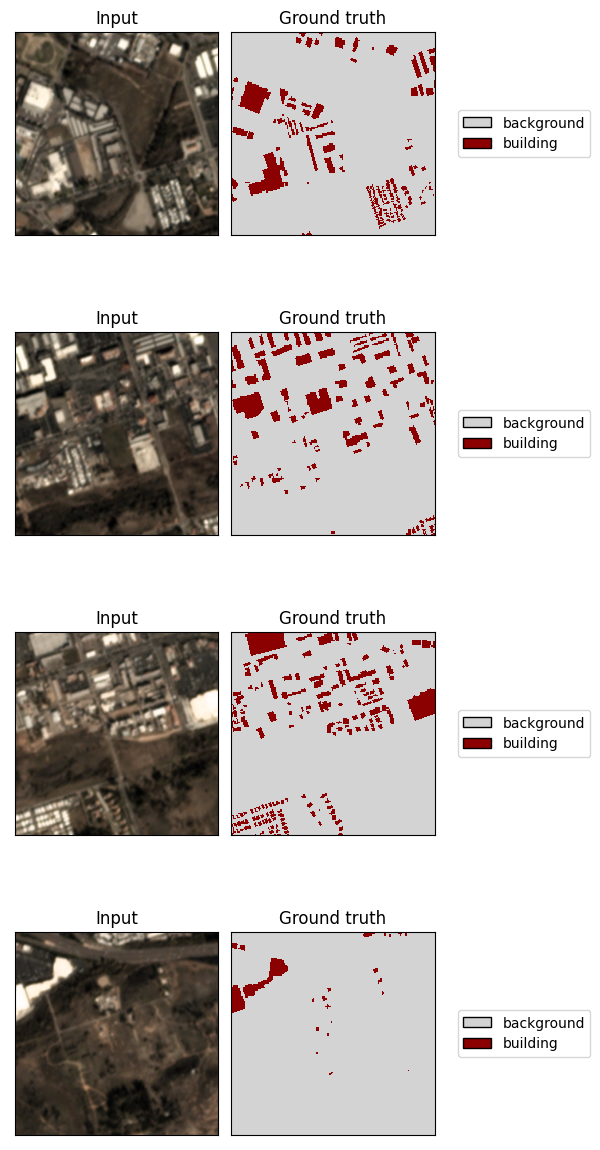

In [7]:
x, y = viz.get_batch(val_ds, 4)
viz.plot_batch(x, y, show=True)

## Define model

Use a [light-weight panoptic FPN model](https://github.com/AdeelH/pytorch-fpn) with a ResNet-18 backbone.

In [9]:
from tqdm.autonotebook import tqdm
import torch
from torch.utils.data import DataLoader
from torch.nn import functional as F
import pytorch_lightning as pl
from rastervision.pipeline.file_system import make_dir

In [10]:
model = torch.hub.load(
    'AdeelH/pytorch-fpn',
    'make_fpn_resnet',
    name='resnet18',
    fpn_type='panoptic',
    num_classes=len(class_config),
    fpn_channels=128,
    in_channels=3,
    out_size=(256, 256),
    pretrained=True)

Using cache found in /root/.cache/torch/hub/AdeelH_pytorch-fpn_master


## Train Model using Lightning

In [11]:
batch_size = 8
lr = 3e-2
epochs = 6
class_loss_weights=[1., 10.]
output_dir = './lightning-demo/'
make_dir(output_dir)
fast_dev_run = False

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size)

In [18]:
class SemanticSegmentation(pl.LightningModule):
    def __init__(self, model, lr=1e-4, loss_weights=None):
        super().__init__()
        self.model = model
        self.lr = lr
        self.loss_weights = (
            torch.tensor(loss_weights).float() if loss_weights else None)

    def training_step(self, batch, batch_idx):
        img, mask = batch
        img = img.float()
        mask = mask.long()
        out = self.model(img)
        loss_val = F.cross_entropy(out, mask, weight=self.loss_weights)
        log_dict = {'train_loss': loss_val}
        return {'loss': loss_val, 'log': log_dict, 'progress_bar': log_dict}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), lr=self.lr)
        return optimizer

In [19]:
semseg = SemanticSegmentation(model, lr=lr, loss_weights=class_loss_weights)
trainer = pl.Trainer(
    min_epochs=1, max_epochs=epochs+1, default_root_dir=output_dir, 
    fast_dev_run=fast_dev_run)
trainer.fit(semseg, train_dl, val_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning-demo/lightning_logs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 12.6 M
-------------------------------------
12.6 M    Trainable params
0         Non-trainable params
12.6 M    Total params
50.260    Total estimated model params size (MB)


A Jupyter Widget

## Visualize a batch of predictions

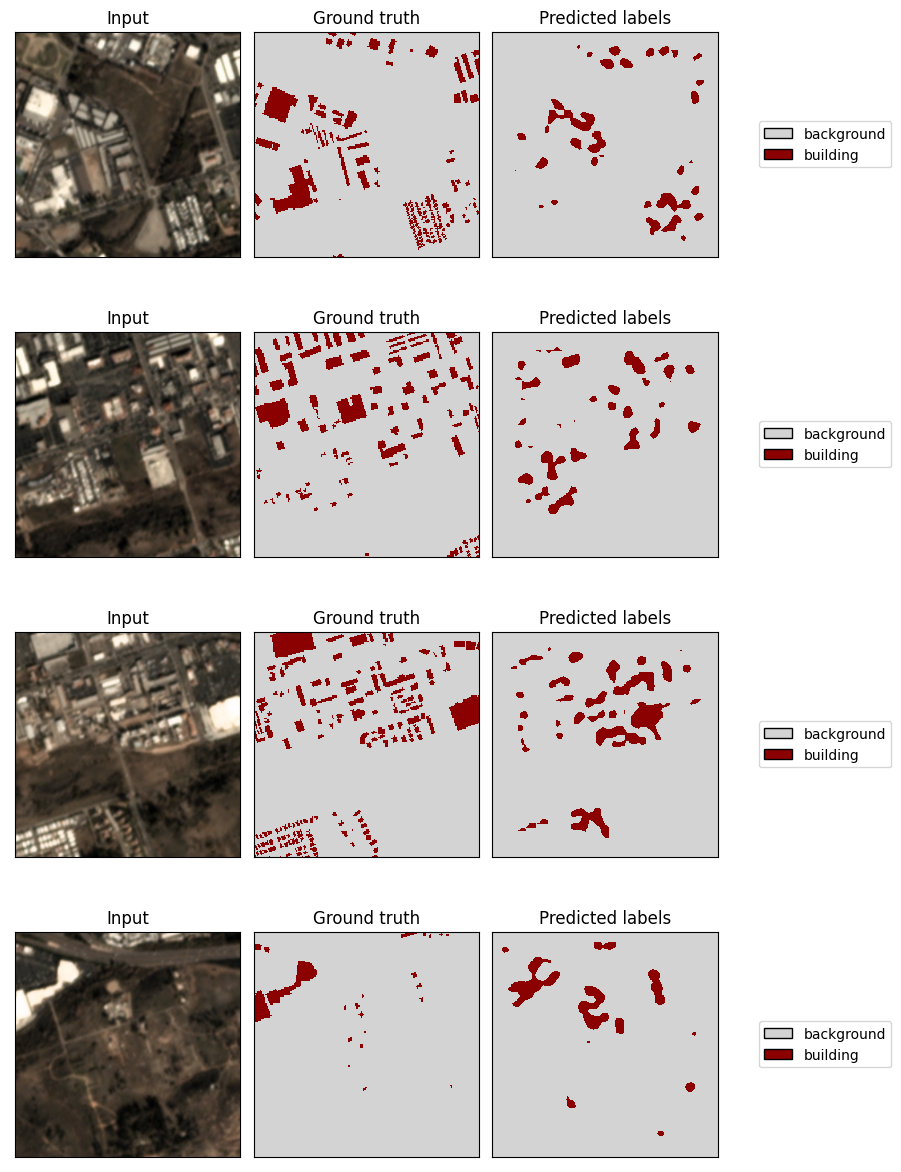

In [20]:
model.eval()

x, y = viz.get_batch(val_ds, 4)
with torch.inference_mode():
    z = model(x)
viz.plot_batch(x, y, z=z, show=True)

## Make predictions for scene

In [21]:
from rastervision.core.data import SemanticSegmentationLabels

def get_predictions(ds):
    for x, _ in tqdm(ds):
        with torch.inference_mode():
            z = model(x.unsqueeze(0)).squeeze(0)
        yield z.numpy()

predictions = get_predictions(val_ds)

pred_labels = SemanticSegmentationLabels.from_predictions(
    val_ds.windows,
    predictions,
    smooth=True,
    extent=val_ds.scene.extent,
    num_classes=len(class_config))

A Jupyter Widget

In [22]:
scores = pred_labels.get_score_arr(pred_labels.extent)

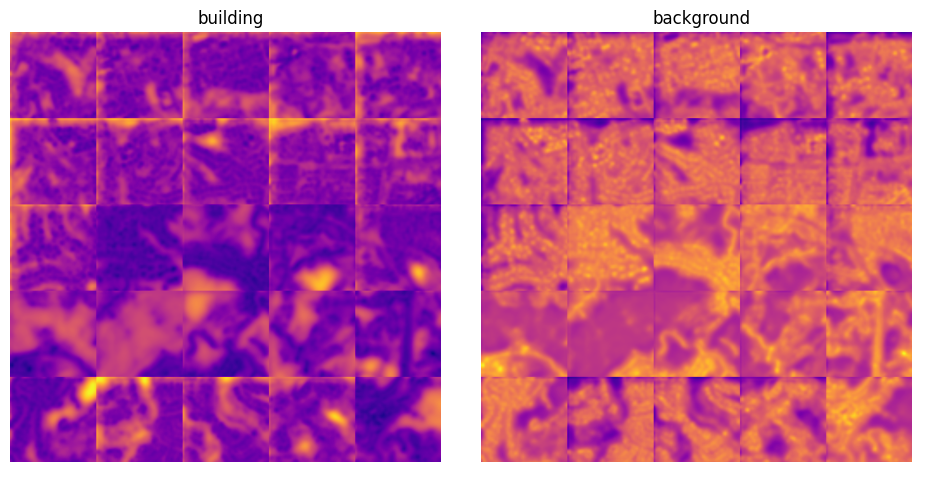

In [23]:
from matplotlib import pyplot as plt

scores_building = scores[0]
scores_background = scores[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(w_pad=-2)
ax1.imshow(scores_building, cmap='plasma')
ax1.axis('off')
ax1.set_title('building')
ax2.imshow(scores_background, cmap='plasma')
ax2.axis('off')
ax2.set_title('background')
plt.show()

In [24]:
from os.path import join

pred_labels.save(
    uri=join(output_dir, 'predictions'),
    crs_transformer=val_ds.scene.raster_source.crs_transformer,
    class_config=class_config)

A Jupyter Widget

A Jupyter Widget

## Evaluate predictions for a scene

In [25]:
from rastervision.core.evaluation import SemanticSegmentationEvaluator

evaluator = SemanticSegmentationEvaluator(class_config)

evaluation = evaluator.evaluate_predictions(
    ground_truth=val_ds.scene.label_source.get_labels(),
    predictions=pred_labels)

In [26]:
evaluation.class_to_eval_item[0]

{'class_id': 0,
 'class_name': 'background',
 'conf_mat': [[11520.0, 59510.0], [156898.0, 819624.0]],
 'conf_mat_dict': {'FN': 156898.0,
                   'FP': 59510.0,
                   'TN': 11520.0,
                   'TP': 819624.0},
 'conf_mat_frac': [[0.010997067448680353, 0.05680863575268817],
                   [0.1497758583822092, 0.7824184384164223]],
 'conf_mat_frac_dict': {'FN': 0.1497758583822092,
                        'FP': 0.05680863575268817,
                        'TN': 0.010997067448680353,
                        'TP': 0.7824184384164223},
 'count_error': 97388.0,
 'gt_count': 976522.0,
 'metrics': {'f1': 0.8833792470156107,
             'precision': 0.9323083852973494,
             'recall': 0.8393297846848304,
             'sensitivity': 0.8393297846848304,
             'specificity': 0.1621849922567929},
 'pred_count': 879134.0,
 'relative_frequency': 0.9321942967986315}

In [27]:
evaluation.class_to_eval_item[1]

{'class_id': 1,
 'class_name': 'building',
 'conf_mat': [[819624.0, 156898.0], [59510.0, 11520.0]],
 'conf_mat_dict': {'FN': 59510.0,
                   'FP': 156898.0,
                   'TN': 819624.0,
                   'TP': 11520.0},
 'conf_mat_frac': [[0.7824184384164223, 0.1497758583822092],
                   [0.05680863575268817, 0.010997067448680353]],
 'conf_mat_frac_dict': {'FN': 0.05680863575268817,
                        'FP': 0.1497758583822092,
                        'TN': 0.7824184384164223,
                        'TP': 0.010997067448680353},
 'count_error': 97388.0,
 'gt_count': 71030.0,
 'metrics': {'f1': 0.09622130901072468,
             'precision': 0.06840123977247088,
             'recall': 0.1621849922567929,
             'sensitivity': 0.1621849922567929,
             'specificity': 0.8393297846848304},
 'pred_count': 168418.0,
 'relative_frequency': 0.06780570320136853}

In [28]:
evaluation.save(join(output_dir, 'evaluation.json'))